# Project: Profiling Davide Frattesi's data
I attempted to visualize some football data in this project, which was either downloaded from FBREF or scraped from Understat.com. In this notebook, I choosed Davide Frattesi to be my use case study as I am a fan of Sassuolo football club. the notebook shows you how to mak the following visualizations cards:
<ul>
    <li> A correlation chart for two metrics </li>
    <li> A shot map showing Davide's typical shooting locations</li>
    <li> Scouting report: Distribution of players according to various metrics and percentile rankings </li> 
</ul>

Let's have fun!

## 1. Imports & Setup Version
Imports:

In [1]:
import requests
import scipy
import bs4
import json
import seaborn
import mplsoccer
import math

import seaborn as sn
import pandas as pd 
import matplotlib.pyplot as plt

from matplotlib.patches import RegularPolygon
from mplsoccer import VerticalPitch, Pitch, FontManager
from PIL import Image
from highlight_text import ax_text
import statistics as stats
from adjustText import adjust_text
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

#import matplotlib.patheffects as path_effects

font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')

# Although some of the modules may be imported with the library, this is primarily for the Setup version.

Setup Version:

In [2]:
print('pandas version: {}'.format(pd.__version__))
print('bs4 version: {}'.format(bs4.__version__))
print('requests version: {}'.format(requests.__version__))
print('mplsoccer version: {}'.format(mplsoccer.__version__))
print('scipy version: {}'.format(scipy.__version__))
print('seaborn version: {}'.format(seaborn.__version__))
print('json version: {}'.format(json.__version__))


pandas version: 1.4.2
bs4 version: 4.11.1
requests version: 2.27.1
mplsoccer version: 1.1.8
scipy version: 1.7.3
seaborn version: 0.11.2
json version: 2.0.9


## 2. A correlation chart for two metrics
This graph aims to show where Davide Frattesi stands in terms of creativity. To achieve so, two FBREF metrics were employed;
<ul>
    <li> Shot-Creating Actions (SCA): an advanced metric that tracks the two offensive/attacking actions that directly lead to a shot on goal.</li>
    <li> Goal-Creating Actions (GCA): an advanced metric that tracks the two offensive/attacking actions that leads to a goal. </li>

In [3]:
# import shot/Creation actions csv files
df= pd.read_csv('data-directory/FBREF/Shot leading actions.csv')
df['Age']= df['Age'].str.split('-', expand= True)[0]

# Remove all the nan values from the Age column
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Keep only non-Nan values
df = df.dropna(subset=['Age'])

# Convert Age datatype to int
df['Age'] = df['Age'].astype('int')

df= df.loc[(df['90s']>=9)  & (df['Pos'].str.contains('MF')) & (df['Comp']== 'it Serie A')]
df= df[['Player','SCA90','GCA90']]

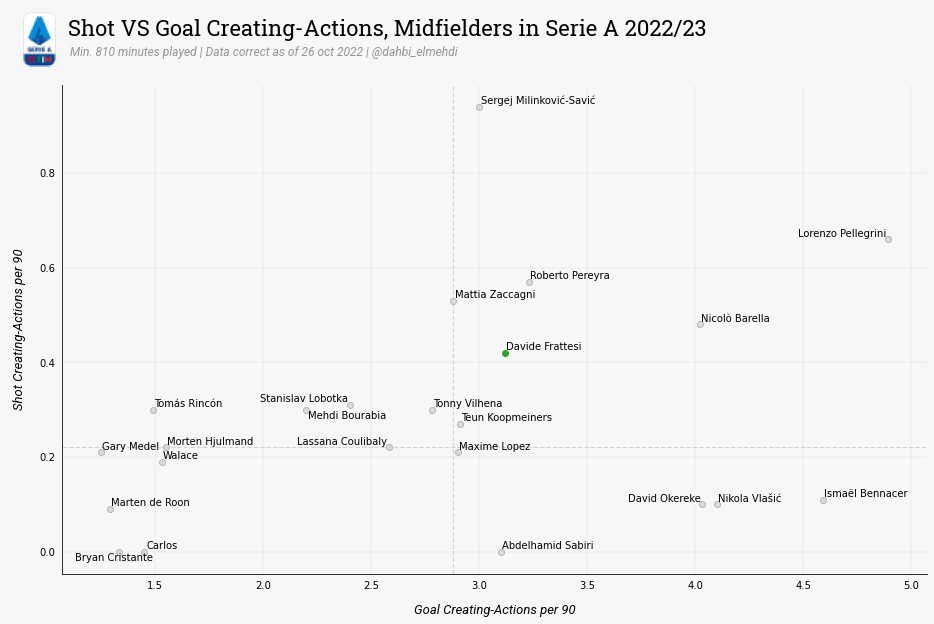

In [4]:
# Create the figure and modify the axis
fig, ax = plt.subplots(figsize=(15.5, 9))
fig.set_facecolor('#f7f7f7')
ax.patch.set_alpha(0)
ax.tick_params(tick1On=False)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.xlabel("Goal Creating-Actions per 90",fontproperties= font_italic.prop, fontsize= 13, labelpad= 13)
plt.ylabel("Shot Creating-Actions per 90",fontproperties= font_italic.prop, fontsize= 13, labelpad= 13)
ax.grid( lw="0.3", color="lightgrey", zorder=1)

# Creation of lists to ease the scattering op
names_ls= df['Player'].values.tolist()
sca90_ls= df['SCA90'].values.tolist()
gca90_ls= df['GCA90'].values.tolist()
texts=[plt.text(sca90_ls[i], gca90_ls[i], names_ls[i]) for i in range(len(names_ls))]

# Add median lines to the chart 
x_median= stats.median(sca90_ls)
y_median= stats.median(gca90_ls)
plt.axhline(y=y_median, xmin =-100, xmax=100, color='lightgrey', linestyle='--', linewidth=1.2)
plt.axvline(x=x_median, ymin=-100,ymax=100, color='lightgrey', linestyle = '--', linewidth=1.2, zorder=0.2)

# Scatter values
for i in range(len(names_ls)):
    if names_ls[i]== 'Davide Frattesi':
        plt.scatter(x= sca90_ls[i], y= gca90_ls[i], c= '#28A828', edgecolors= '#28A828' )
    else:
        plt.scatter(x= sca90_ls[i], y= gca90_ls[i], c= '#dbdbdb', edgecolors= '#b6b6b6')
adjust_text(texts)

# Add title and suptitle
title_text= "Shot VS Goal Creating-Actions, Midfielders in Serie A 2022/23"
subtitle= "Min. 810 minutes played | Data correct as of 26 oct 2022 | @dahbi_elmehdi"
fig.text(0.13, 0.955, title_text, fontsize=22, fontweight= 'bold', color='black', fontproperties= font_bold.prop)
fig.text(0.132, 0.925, subtitle, fontsize=12, color='black',fontproperties= font_italic.prop,alpha=.4)

# Add Serie A logo
img_dir= "pictures/Serie A.png"    
ax= fig.add_axes([0.05, .9, 0.11, 0.1])
ax.axis("off")
img = Image.open(img_dir)
ax.imshow(img)

# save figure
plt.savefig("outcomes/Frattesi's creativity.png", dpi=150, bbox_inches='tight')

## 3.The Shot map showing Davide's typical shooting locations
### a) Understat scraping
You can search for Frattesi on Understat.com to uncover various pieces of information about his performances. We'll scrape what we find interesting: shots data.

In [5]:
base_url = 'https://understat.com/player/'

def playerShots(id):
    
    url = base_url + str(id)
    result = requests.get(url)
    soup = BeautifulSoup(result.content, 'lxml')
    scripts = soup.find_all('script')
    shots = scripts[3].string
    index_start = shots.index("('")+2
    index_end = shots.index("')")
    json_data = shots[index_start:index_end]
    json_data = json_data.encode('utf8').decode('unicode_escape') 
    data = json.loads(json_data)
    df = pd.DataFrame.from_dict(data)
    
    for r in range(len(df.index)):
        df.X[r]=pd.to_numeric(df.X[r])
        df.Y[r]=pd.to_numeric(df.Y[r])
        
    return df

# The link of Fratessi's web page on Understat.com conatins his id 'https://understat.com/player/4981'
fratessi_df= playerShots(4981)
fratessi_df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,427238,16,SavedShot,0.701,0.62,0.01453977171331644,Davide Frattesi,a,4981,OpenPlay,2021,RightFoot,16756,Verona,Sassuolo,2,3,2021-08-21 16:30:00,Maxime Lopez,Pass
1,427253,66,MissedShots,0.758,0.469,0.025870678946375847,Davide Frattesi,a,4981,OpenPlay,2021,LeftFoot,16756,Verona,Sassuolo,2,3,2021-08-21 16:30:00,Francesco Caputo,Pass
2,427255,68,SavedShot,0.876,0.479,0.16766619682312012,Davide Frattesi,a,4981,OpenPlay,2021,LeftFoot,16756,Verona,Sassuolo,2,3,2021-08-21 16:30:00,None,TakeOn
3,427254,68,BlockedShot,0.816,0.467,0.13934415578842163,Davide Frattesi,a,4981,OpenPlay,2021,RightFoot,16756,Verona,Sassuolo,2,3,2021-08-21 16:30:00,Francesco Caputo,Throughball
4,429341,42,MissedShots,0.818,0.504,0.04468480497598648,Davide Frattesi,h,4981,OpenPlay,2021,LeftFoot,16772,Sassuolo,Sampdoria,0,0,2021-08-29 16:30:00,None,Rebound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,496033,54,BlockedShot,0.874,0.381,0.10011013597249985,Davide Frattesi,h,4981,OpenPlay,2022,RightFoot,18690,Sassuolo,Verona,2,1,2022-10-24 18:45:00,Luca D&#039;Andrea,TakeOn
92,496036,58,BlockedShot,0.856,0.554,0.09613072127103806,Davide Frattesi,h,4981,OpenPlay,2022,RightFoot,18690,Sassuolo,Verona,2,1,2022-10-24 18:45:00,Georgios Kyriakopoulos,Pass
93,496041,73,Goal,0.944,0.602,0.3116515874862671,Davide Frattesi,h,4981,OpenPlay,2022,RightFoot,18690,Sassuolo,Verona,2,1,2022-10-24 18:45:00,Hamed Junior Traore,Cross
94,496315,56,SavedShot,0.883,0.494,0.10668398439884186,Davide Frattesi,a,4981,OpenPlay,2022,RightFoot,18699,Napoli,Sassuolo,4,0,2022-10-29 13:00:00,Jeremy Toljan,Pass


In [6]:
# Lets filter his shots data so we kep only those performed during the current season
fratessi_df['xG'] = fratessi_df['xG'].astype('float64')
fratessi_df= fratessi_df.loc[(fratessi_df['season']=='2022') & (fratessi_df['situation']== 'OpenPlay')]
fratessi_df['X']= fratessi_df['X']*100
fratessi_df['Y']= fratessi_df['Y']*100

C:\Users\pc\AppData\Local\Temp\ipykernel_12588\4291389557.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fratessi_df['X']= fratessi_df['X']*100
C:\Users\pc\AppData\Local\Temp\ipykernel_12588\4291389557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fratessi_df['Y']= fratessi_df['Y']*100


### b) Visualization of shots data

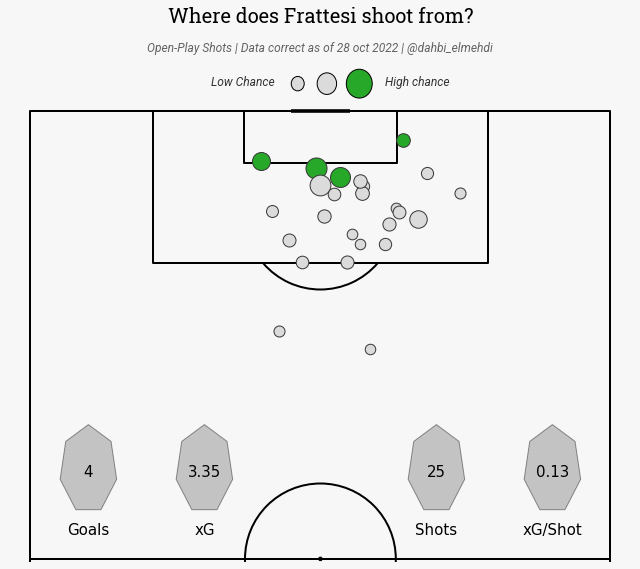

In [7]:
# Create th pitch
pitch = VerticalPitch(pitch_type= 'opta',pad_bottom=0.5, half= True, goal_alpha=0.8,
                      pitch_color= '#f7f7f7', line_color='black') 
fig, ax = pitch.draw(figsize=(9, 10))
fig.set_facecolor('#f7f7f7')

result= fratessi_df['result'].values.tolist()
X_s= fratessi_df['X'].values.tolist()
Y_s= fratessi_df['Y'].values.tolist()
xG_s= fratessi_df['xG'].values.tolist()

# Scatter shots 
for r, x, y, xG in zip(result, X_s, Y_s, xG_s):
    if r == 'Goal':
        pitch.scatter(x, y, c='#28A828', s=(xG* 720) + 100,
                      edgecolors='#383838', ax=ax)
    else:
        pitch.scatter(x, y, c='#dbdbdb', s=(xG* 720) + 100,
                      edgecolors='#383838', ax=ax)

# Add the regular polygons to show more shots related data        
goals= fratessi_df.loc[fratessi_df['result']=='Goal']
placements= [90, 70, 30, 10]
texts= ['Goals', 'xG', 'Shots', 'xG/Shot']
metrics= [len(goals), "{:.2f}".format(sum(fratessi_df['xG'])), len(fratessi_df),
          "{:.2f}".format(sum(fratessi_df['xG'])/len(fratessi_df)) ]

# This section is heaviliy inspired from @sonofacorner
for p, m, t in zip(placements, metrics, texts):
    
    hex_annotation = RegularPolygon((p, 60), numVertices=7, radius=5, edgecolor='black', fc='None',
                                    hatch='.........', lw=1, alpha= .4)
    ax.add_patch(hex_annotation)
    
    ax.annotate(
    xy=(p,60),
    text=m,
    xytext=(0,-2),
    textcoords='offset points',
    size=15,
    ha='center',
    va='center'
    )
    ax.annotate(
    xy=(p,60),
    text=t,
    xytext=(0,-60),
    textcoords='offset points',
    size=15,
    ha='center',
    va='center'
    )

    
fig.patches.extend([
    plt.Circle(
        (0.465, 0.835),0.01, fill=True, color="#dbdbdb", ec= 'black', lw=1,
        transform=fig.transFigure, figure=fig
    ),
    plt.Circle(
        (0.51, 0.835), 0.015, fill=True, color="#dbdbdb", ec= 'black', lw=1,
        transform=fig.transFigure, figure=fig
    ),
    plt.Circle(
        (0.56, 0.835), 0.02, fill=True, color="#28A828", ec= 'black', lw=1,
        transform=fig.transFigure, figure=fig
    ),
])

# Expected goal legend
fig.text(0.38, 0.8333, 'Low Chance', fontsize=12, color='black',fontproperties= font_italic.prop,alpha=.8, ha='center')
fig.text(0.65, 0.8333, 'High chance', fontsize=12, color='black',fontproperties= font_italic.prop,alpha=.8, ha='center')

# Add title and subtitle
title_text= "Where does Frattesi shoot from?"
subtitle= "Open-Play Shots | Data correct as of 28 oct 2022 | @dahbi_elmehdi"
fig.text(0.5, 0.92, title_text, fontsize=20, color='black', fontproperties= font_bold.prop, ha='center')
fig.text(0.5, 0.88, subtitle, fontsize=12, color='black',fontproperties= font_italic.prop,alpha=.6, ha='center')

# Save figure
plt.savefig("outcomes/Frattesi's shot map.png", dpi=150, bbox_inches='tight')

## 4. Scouting report: Distribution of players according to various metrics and percentile rankings
### a) Metrics preparation

In [8]:
# Profile's data Viz
possession_df= pd.read_csv('data-directory/FBREF/possession play.csv')
possession_df = possession_df.dropna(subset=['Age'])

shooting_df= pd.read_csv('data-directory/FBREF/Shooting.csv')
shooting_df = shooting_df.dropna(subset=['Age'])

passing_df= pd.read_csv('data-directory/FBREF/passing.csv')
passing_df = passing_df.dropna(subset=['Age'])

sca_df= pd.read_csv('data-directory/FBREF/Shot leading actions.csv')
sca_df = sca_df.dropna(subset=['Age'])

defActions_df= pd.read_csv('data-directory/FBREF/Defensive actions.csv')
defActions_df = defActions_df.dropna(subset=['Age'])

#These are the metrics we need to extract:
#     Non-penalty xG        
#     xAG                
#     npxG + xAG            
#     Goal-creating-Actions          
#     Progressive passes             
#     Dribbles completed          
#     Progressive passes received        
#     Touches in the attacking third        
#     Interceptions     
#     tackles 

data= {
       'Player': sca_df['Player'],
       'Nation': sca_df['Nation'],
       'Pos': sca_df['Pos'],
       'Comp': sca_df['Comp'],
       '90s': sca_df['90s'], 
       'npxG/Sh': shooting_df['npxG/Sh'],
       'npxG': shooting_df['npxG'],
       'xAG': passing_df['xAG'],
       'SCA90+GCA90': sca_df['GCA90']+ sca_df['SCA90'],
       'touches att': possession_df['Att Pen'], 
       'Prog received': possession_df['Prog'],
       'succ dribbles': possession_df['Succ'],
       'Prog passes': passing_df['Prog'],
       'Tkl+Int': defActions_df['Tkl+Int'] 
      }

df= pd.DataFrame(data)


# Keep only non-Nan values
df = df.dropna(subset=['90s'])

# Let us filter our data to keep Serie A midfielders who have played more than 5 90s
df= df.loc[(df['Comp']=='it Serie A') & (df['Pos'].str.contains('MF')) & ( df['90s']>=5)] 

Calculating percentiles of Davide Fratessi;

In [9]:
frattesi_ls= df.loc[df['Player']== 'Davide Frattesi'].values.tolist()[0][5:]
metrics= df.columns.values.tolist()[5:]
values = []

for x in range(len(metrics)):
    values.append(math.floor(scipy.stats.percentileofscore(df[metrics[x]], frattesi_ls[x])))
    
    # To print the output of this for loop
    print(metrics[x],math.floor(scipy.stats.percentileofscore(df[metrics[x]], frattesi_ls[x])))

npxG/Sh 23
npxG 68
xAG 77
SCA90+GCA90 68
touches att 70
Prog received 61
succ dribbles 26
Prog passes 70
Tkl+Int 53


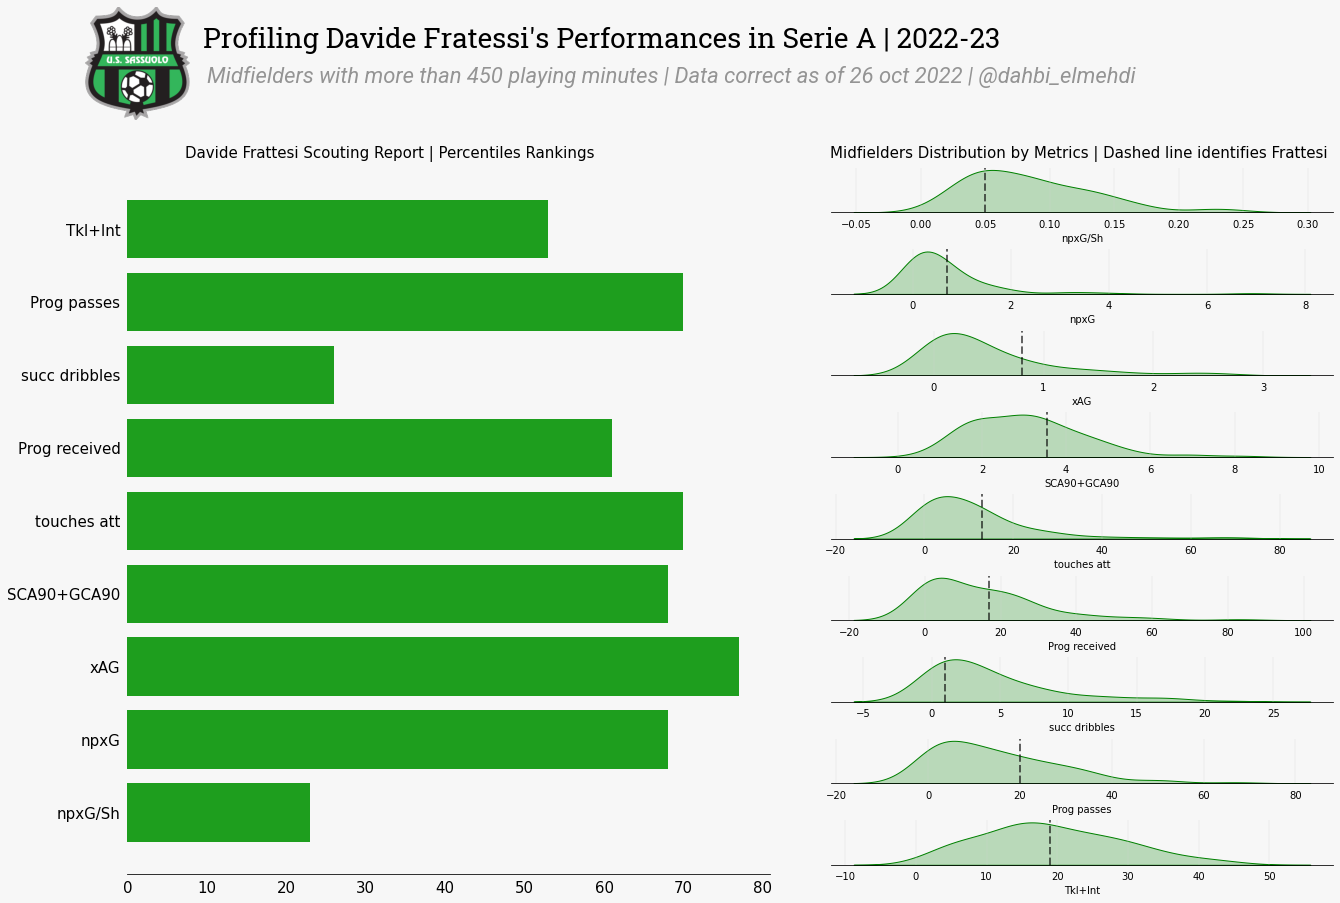

In [10]:
# Set the figure 
fig = plt.figure(layout="constrained")
fig.set_size_inches(18.5, 10.5)
fig.set_facecolor('#f7f7f7')

# Set the distribution of axis (9 for players distibution metrics/ 1 for the percntiles rankings)
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1.5, 1.])
axs0 = subfigs[0].subplots(1, 1)
subfigs[0].suptitle('Davide Frattesi Scouting Report | Percentiles Rankings', fontsize=15)
axs0.barh(metrics, values, align='center', color= '#1E9E1E')
axs0.tick_params(tick1On=False, labelsize=15)

# Set the visibility of axes
axs0.spines.left.set_visible(False)
axs0.spines.right.set_visible(False)
axs0.spines.top.set_visible(False)
axs0.patch.set_alpha(0)

axs1 = subfigs[1].subplots(9, 1)
subfigs[1].suptitle('Midfielders Distribution by Metrics | Dashed line identifies Frattesi', fontsize=15)
fig.set_size_inches(18.5, 10.5)

# make the distribution plots 
for i in range(len(axs1)):
    
    axs1[i].tick_params(tick1On=False)
    axs1[i].axes.yaxis.set_ticklabels([])
    axs1[i].spines.left.set_visible(False)
    axs1[i].spines.right.set_visible(False)
    axs1[i].spines.top.set_visible(False)
    axs1[i].axes.yaxis.set_visible(False)
    axs1[i].grid( lw="0.3", color="lightgrey", zorder=1)
    axs1[i].patch.set_alpha(0)
    
    sn.kdeplot(df[metrics[i]],color='green',shade=True, ax= axs1[i])
    axs1[i].axvline(x= frattesi_ls[i], color='black', alpha= .6, ls='--', lw=2)

# Add Sassuolo's logo to the scouting card
img_dir= "pictures/sassuolo.png"    
axs0= fig.add_axes([0.025, 1.03, 0.15, 0.15])
axs0.axis("off")
img = Image.open(img_dir)
axs0.imshow(img)

# Add the title and subtitle
title_text= "Profiling Davide Fratessi's Performances in Serie A | 2022-23"
subtitle= "Midfielders with more than 450 playing minutes | Data correct as of 26 oct 2022 | @dahbi_elmehdi"
fig.text(0.149, 1.126, title_text, fontsize=28, fontweight= 'bold', color='black', fontproperties= font_bold.prop)
fig.text(0.152, 1.08, subtitle, fontsize=22, color='black',fontproperties= font_italic.prop,alpha=.4)

# save figure
plt.savefig("outcomes/Frattesi's scouting report.png", dpi=150, bbox_inches='tight')


## 5. Bonus: On the field, where does Fratessi frequently play?

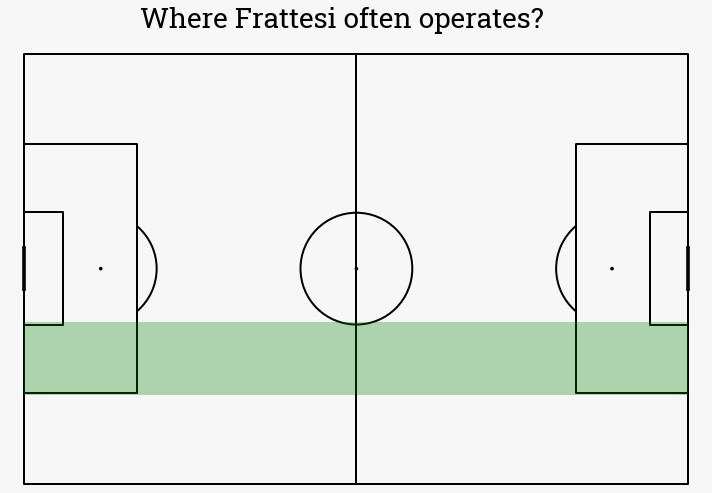

In [11]:
#Set the pitch
pitch= Pitch(pitch_type= 'opta', pad_bottom=0.5, goal_alpha=0.8,
                      pitch_color= '#f7f7f7', line_color='black') 
fig, ax = pitch.draw(figsize=(10, 12))
fig.set_facecolor('#f7f7f7')

# Add the green rectangle
ax.add_patch(plt.Rectangle((0, 20.5), 100, 17,
             facecolor = 'green',
             fill=True,
             alpha=0.3,
             lw=5))
# Add title  
title_text= "Where Frattesi often operates?"
fig.text(0.2, 0.77, title_text, fontsize=28, fontweight= 'bold', color='black', fontproperties= font_bold.prop)

plt.savefig("outcomes/position.png", dpi=150, bbox_inches='tight')